In [53]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tqdm import *
import zipfile
from PIL import Image
import keras
import pickle
# from keras import backend as K
from __future__ import division, print_function

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from random import shuffle
import itertools
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import os
import numpy as np
import itertools

import os
%matplotlib inline

In [54]:
base_path = "/home/grozin/.kaggle/competitions/avito-demand-prediction/"
train_image_base_path = base_path + "data/competition_files/train_jpg/"
test_image_base_path = base_path + "data/competition_files/test_jpg/"

In [55]:
import pandas as pd

training = pd.read_csv(base_path + 'train.csv', index_col = "item_id", parse_dates = ["activation_date"])
testing = pd.read_csv(base_path + 'test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testing_imgs = testing["image"][~testing["image"].isnull()]
training_imgs = training["image"][~training["image"].isnull()]

In [56]:
from scipy.stats import itemfreq
import operator
import cv2
from skimage import feature
from collections import defaultdict

In [57]:
from os import listdir
from os.path import isfile, join
train_images = listdir(train_image_base_path)
test_images = listdir(test_image_base_path)

# Getting features

In [ ]:
def color_analysis(img):
    # obtain the color palatte of the image 
    palette = defaultdict(int)
    for pixel in img.getdata():
        palette[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palette.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 1, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

def color_analysis2(img):
    return np.sum(np.where(np.all(img < 20, axis=2))) / img.size, np.sum(np.where(np.all(img > 240, axis=2))) / img.size

In [ ]:
def average_pixel_width(img):
    im_array = np.asarray(img.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (img.size[0]*img.size[1]))
    return apw*100

In [ ]:
img_f = image.load_img(train_image_base_path + train_images[123])
target_size = (224, 224)
img_rescaled = img_f.resize(target_size)
img_rescaled = image.img_to_array(img_rescaled)

dom_c = get_dominant_color(cv2.cvtColor(img_rescaled, cv2.COLOR_RGB2YUV))
print(dom_c)

In [ ]:
np.array([get_dominant_color(cv2.cvtColor(np.array([[[227.707    ,  -1.8158445,  -1.8740396]]]), cv2.COLOR_YUV2RGB))])

In [ ]:
cv2.cvtColor(cv2.cvtColor(img_rescaled[:1, :1, :], cv2.COLOR_RGB2YUV), cv2.COLOR_YUV2RGB)

In [ ]:
img_rescaled[:1, :1, :]

In [ ]:
def get_average_color(img):
    average_color = [img[:, :, i].mean() for i in range(img.shape[-1])]
    return average_color

In [ ]:
def get_size(filename):
    filename = filename
    st = os.stat(filename)
    return st.st_size

def get_dimensions(img):
    img_size = img.size
    return img_size

In [ ]:
def get_blurrness_score(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [ ]:
import keras.applications.inception_v3 as inception_v3

def classify_by_model(model, bak, img):
    """Classify image and return top match."""
    x = bak.preprocess_input(img)
    preds = model.predict(x)
    return int(np.argmax(preds)), np.max(preds) # bak.decode_predictions(preds, top=1)[0][0]

In [ ]:
def get_simple_img_features(filename, inception_model):
    img_f = image.load_img(filename)
    img = image.img_to_array(img_f)
    
    target_size = (224, 224)
    img_rescaled = img_f.resize(target_size)
    img_rescaled = np.array([image.img_to_array(img_rescaled)])
    
    return np.array(
        [get_blurrness_score(np.array(img, np.uint16)),
          get_size(filename), 
          get_dimensions(img),
          img.shape[0], img.shape[1], 
          *get_average_color(img),
          average_pixel_width(img_f),
          *color_analysis2(img),
          *classify_by_model(inception_model, inception_v3, img_rescaled)
        ])

In [ ]:
simple_img_features_names = [
    "burrness", 
    "size", "dims",
    "w", "h", 
    "avg_color_r", "avg_color_g", "avg_color_b",
    "pixel_w",
    "light", "darkness", "img_class", "img_proba"]

In [ ]:
import traceback


In [ ]:
import threading
from time import time

def process_img_features(worker_id, imgs_full_paths, imgs):
    with open(str(worker_id) + "_img.pickle", "wb") as f:
        graph1 = tf.Graph()
        with graph1.as_default():
            with tf.Session(graph=graph1) as sess:
                inception_model = inception_v3.InceptionV3(weights='imagenet')
                start_time = time()
                for i, (img_full_path, img_tag) in enumerate(zip(imgs_full_paths, imgs)):
                    try:
                        if i % 150 == 0:
                            dt = int(time() - start_time)
                            print(worker_id, i, "/", len(imgs), " (time from start: ", dt, ")")
                            speed = float(i + 1) / float(dt + 1.0)
                            print((len(imgs) - i) / speed)
                        pickle.dump((img_tag, get_simple_img_features(img_full_path, inception_model)), f)
                    except:
                        traceback.print_exc()

In [ ]:
imgs = []
img_full_paths = []
for x in testing_imgs:
    imgs.append(x)
    img_full_paths.append(test_image_base_path + x + ".jpg")
    
for x in training_imgs:
    imgs.append(x)
    img_full_paths.append(train_image_base_path + x + ".jpg")

In [ ]:
# imgs = imgs[:4000]
# img_full_paths = img_full_paths[:4000]

In [ ]:
thread_count = 8
threads = []

for i, thread_fp, thread_imgs in zip(range(thread_count),
           np.array_split(np.array(img_full_paths), thread_count),
           np.array_split(np.array(imgs), thread_count)):
    threads.append(threading.Thread(target=process_img_features, args = ([i, thread_fp, thread_imgs])))

In [ ]:
for i in range(thread_count):
    threads[i].start()
for i in range(thread_count):
    threads[i].join()

## Throwing in few classifier features

In [ ]:
inception_model = inception_v3.InceptionV3(weights='imagenet')
vgg_model = vgg19.VGG19(weights='imagenet')

In [ ]:
img = Image.open(train_image_base_path + train_images[5])
target_size = (224, 224)
if img.size != target_size:
    img = img.resize(target_size)
img = np.array([image.img_to_array(img)])

x = inception_v3.preprocess_input(img)
preds = inception_model.predict(x)

In [ ]:
import threading
import tensorflow as tf

def process_image_class(worker_id, imgs_full_path, imgs):
    graph1 = tf.Graph()
    with graph1.as_default():
        with tf.Session(graph=graph1) as sess:
            inception_model = inception_v3.InceptionV3(weights='imagenet')
            vgg_model = vgg19.VGG19(weights='imagenet')
            with open(str(worker_id) + "_img_classes.pickle", "wb") as f:
                for i, (img_full_path, img_tag) in enumerate(zip(imgs_full_path, imgs)):
                    if i % 100 == 0:
                        print(worker_id, i)
                    try:
                        img = Image.open(img_full_path)
                        target_size = (224, 224)
                        if img.size != target_size:
                            img = img.resize(target_size)
                        img = np.array([image.img_to_array(img)])
                        results = classify_by_model(inception_model, inception_v3, img.copy())
                        pickle.dump((img_tag, results), f)
                    except:
                        pass

In [ ]:
thread_count = 4
threads = []
img_full_paths = [(train_image_base_path + x) for x in train_images] + [(test_image_base_path + x) for x in test_images]
imgs = train_images + test_images

# img_full_paths = img_full_paths[:1000]
# imgs = imgs[:1000]
print(len(img_full_paths), len(imgs))
for i, thread_fp, thread_imgs in zip(range(thread_count),
                   np.array_split(np.array(img_full_paths), thread_count),
                   np.array_split(np.array(imgs), thread_count)):
    threads.append(threading.Thread(target=process_image_class, args = ([i, thread_fp, thread_imgs])))

In [ ]:
from time import time
a = time()
for i in range(thread_count):
    threads[i].start()
for i in range(thread_count):
    threads[i].join()
time() - a

# HSV / YUV features

In [ ]:
import cv2

def get_dominant_color(img):
    pixels = img.reshape((-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, .3)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 5, flags)

    palette = centroids
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    counts = np.unique(labels, return_counts=True)[1]
    count_indices = np.argsort(-counts)
    return np.concatenate([palette[count_indices[0]], palette[count_indices[1]], \
            [counts[count_indices[0]] / sum(counts)], \
            [counts[count_indices[1]] / sum(counts)]])\


def palette_features(filename):
    img_f = image.load_img(filename)
    img = image.img_to_array(img_f)
    
    target_size = (224, 224)
    img_rescaled = img_f.resize(target_size)
    rgb_array = image.img_to_array(img_rescaled)
    
    yuv_array = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2YUV)
    hls_array = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2HLS)

    rg = rgb_array[:, :, 0] - rgb_array[:, :, 1]
    yb = (rgb_array[:, :, 0] + rgb_array[:, :, 1]) / 2 - rgb_array[:, :, 2]
    cful = [np.sqrt(np.var(rg) + np.var(yb)) + 0.3 * np.sqrt(np.mean(rg) ** 2.0 + np.mean(yb) ** 2.0)]

    features = np.concatenate([
        cful,
        get_dominant_color(rgb_array),
        np.mean(yuv_array, axis=(0, 1)),
        np.var(yuv_array, axis=(0, 1)),
        np.mean(hls_array, axis=(0, 1)),
        np.var(hls_array, axis=(0, 1))
    ])
    return features

In [ ]:
pal_feature_names = [
    "cful",
    "dom1y", "dom1u", "dom1v",
    "dom2y", "dom2u", "dom2v",
    "dom1portion", "dom2portion",
    "ymean", "umean", "vmean",
    "yvar", "uvar", "vvar",
    "hmean", "lmean", "smean",
    "hvar", "lvar", "svar",
]

In [ ]:
import traceback
import threading
from time import time

def process_img_pal_features(worker_id, imgs_full_paths, imgs):
    with open(str(worker_id) + "_pal.pickle", "wb") as f:
        graph1 = tf.Graph()
        with graph1.as_default():
            with tf.Session(graph=graph1) as sess:
                start_time = time()
                for i, (img_full_path, img_tag) in enumerate(zip(imgs_full_paths, imgs)):
                    try:
                        if i % 150 == 0:
                            dt = int(time() - start_time)
                            print(worker_id, i, "/", len(imgs), " (time from start: ", dt, ")")
                            speed = float(i + 1) / float(dt + 1.0)
                            print((len(imgs) - i) / speed)
                        pickle.dump((img_tag, palette_features(img_full_path)), f)
                    except:
                        traceback.print_exc()

In [ ]:
thread_count = 16
threads = []
img_full_paths = [(train_image_base_path + x) for x in train_images] + [(test_image_base_path + x) for x in test_images]
imgs = train_images + test_images

# img_full_paths = img_full_paths[:1000]
# imgs = imgs[:1000]

print(len(img_full_paths), len(imgs))
for i, thread_fp, thread_imgs in zip(range(thread_count),
                   np.array_split(np.array(img_full_paths), thread_count),
                   np.array_split(np.array(imgs), thread_count)):
    threads.append(threading.Thread(target=process_img_pal_features, args = ([i, thread_fp, thread_imgs])))

In [ ]:
from time import time
a = time()
for i in range(thread_count):
    threads[i].start()
for i in range(thread_count):
    threads[i].join()
time() - a

# Segment features

In [1]:
import cv2

In [166]:
from pyimgsaliency import get_saliency_ft, get_saliency_rbd, get_saliency_mbd
import matplotlib.pyplot as plt
import cv2

feat5 = cv2.FastFeatureDetector_create(5)
feat10 = cv2.FastFeatureDetector_create(10)
feat20 = cv2.FastFeatureDetector_create(20)

cont_thresholds = [64, 128, 192]
area_thresholds = [5, 100, 500]
def get_saliency_features(filename):
    img_f = image.load_img(filename)
    img = image.img_to_array(img_f)
    
    target_size = (128, 128)
    img_rescaled = img_f.resize(target_size)
    rgb_array = image.img_to_array(img_rescaled)
    
    kp5 = feat5.detect(rgb_array, None)
    kp10 = feat10.detect(rgb_array, None)
    kp20 = feat20.detect(rgb_array, None)
    
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
    contour_features = []
    
    for thresh in cont_thresholds:        
        _, ret = cv2.threshold(img, thresh, 255, 0)
        im2, contours, _ = cv2.findContours(ret, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        areas = np.array([cv2.contourArea(x) for x in contours])
        contour_features.append(np.sum(ret))
        contour_features.append(len(contours))
        if len(areas) == 0:
            contour_features.append(-1)
        else:
            contour_features.append(max(areas))
        for a in area_thresholds:
            contour_features.append(sum(areas > a))
        
    return [len(kp5), len(kp10), len(kp20)] + contour_features

feature_names = ["kp5", "kp10", "kp20"]
for thresh in cont_thresholds:        
    feature_names.append("mask_size_" + str(thresh))
    feature_names.append("contour_size_" + str(thresh))
    feature_names.append("largest_contour_size_" + str(thresh))
    for a in area_thresholds:
        feature_names.append("contours_" + str(thresh) + "_larger_" + str(a))

In [ ]:
import pickle

with open("contour_map.pickle", "wb") as f:
    for x in tqdm(test_images):
        try:
            features = get_saliency_features(test_image_base_path + x)
            pickle.dump((x, features), f)
        except:
            traceback.print_exc()
    for x in tqdm(train_images):
        try:
            features = get_saliency_features(train_image_base_path + x)
            pickle.dump((x, features), f)
        except:
            traceback.print_exc()

 66%|██████▋   | 924050/1390836 [7:31:30<3:48:04, 34.11it/s]

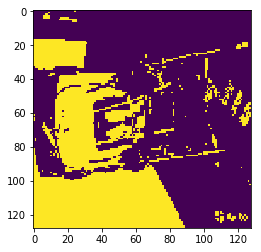

In [140]:
from keras.preprocessing import image

# ft = get_saliency_ft(filename).astype('uint8')
# get_saliency_rbd('/home/grozin/.kaggle/competitions/avito-demand-prediction/data/competition_files/train_jpg/f1069b755cb5dbb00dd887765197511c2b17e28ee4fd0be0c6808df3d3c6d9b1.jpg').astype('uint8')
# get_saliency_ft('/home/grozin/.kaggle/competitions/avito-demand-prediction/data/competition_files/train_jpg/f1069b755cb5dbb00dd887765197511c2b17e28ee4fd0be0c6808df3d3c6d9b1.jpg').astype('uint8')
# get the saliency maps using the 3 implemented methods
# plt.imshow(get_saliency_rbd(train_image_base_path + train_images[1000]).astype('uint8'))
img_f = image.load_img(train_image_base_path + train_images[1000])

target_size = (128, 128)
img_rescaled = img_f.resize(target_size)
img = image.img_to_array(img_rescaled).astype('uint8')
import numpy as np
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

ret, thresh = cv2.threshold(img, 128, 255, 0)
im2, contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
mask = np.zeros(img.shape, np.uint8)
cv2.fillPoly(mask, [largest_contour], 128)

# apply mask to threshold image to remove outside. this is our new mask
#plt.imshow(get_saliency_rbd(arr, 120).astype('uint8'))
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
#img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
#img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
#img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
#img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
#img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
plt.imshow(im2.astype('uint8'))

/home/grozin/kaggle/demand_prediction/saliency.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  vertices[x/num_vertices]] for x in edges]


CPU times: user 588 ms, sys: 0 ns, total: 588 ms
Wall time: 586 ms


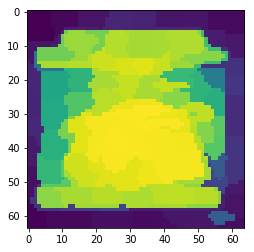

In [15]:
%time plt.imshow(get_saliency_rbd(arr, 100, 20).astype('uint8'))

In [ ]:
filename = train_image_base_path + train_images[0]

img_f = image.load_img(filename)
img = image.img_to_array(img_f)

target_size = (224, 224)
img_rescaled = img_f.resize(target_size)
rgb_array = image.img_to_array(img_rescaled)

feat = cv2.FastFeatureDetector_create()

kp = feat.detect(img, None)

### Checking validity, processing leftovers

In [ ]:
processed_class_ids = []
for i in range(8):
    with open(str(i) + "_img_classes.pickle", "rb") as f:
        while True:
            try:
                pair = pickle.load(f)
                processed_class_ids.append(pair[0])
            except:
                break

In [ ]:
processed_feature_ids = []
for i in range(8):
    with open(str(i) + "_features.pickle", "rb") as f:
        while True:
            try:
                pair = pickle.load(f)
                processed_feature_ids.append(pair[0])
            except:
                break
    with open(str(i) + "_features_test.pickle", "rb") as f:
        while True:
            try:
                pair = pickle.load(f)
                processed_feature_ids.append(pair[0])
            except:
                break

In [ ]:
processed_class_ids = set(processed_class_ids)
processed_feature_ids = set(processed_feature_ids)

In [ ]:
sum(~training["image"][~training["image"].isnull()].apply(lambda x: x + ".jpg" in processed_class_ids))

In [ ]:
sum(~testing["image"][~testing["image"].isnull()].apply(lambda x: x + ".jpg" in processed_class_ids))

# Background extraction

In [ ]:
import torch
from torch import nn
from TernausNet.unet_models import unet11
from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_model():
    model = unet11(pretrained='carvana')
    model.eval()
    return model.to(device)

def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def crop_image(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2] 
    
    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]

model = get_model()

In [ ]:
import matplotlib.pyplot as plt
img, pads = load_image(train_image_base_path + train_images[101], pad=True)
with torch.no_grad():
    input_img = torch.unsqueeze(img_transform(img).to(device), dim=0)
with torch.no_grad():
    mask = F.sigmoid(model(input_img))
mask_array = mask.data[0].cpu().numpy()[0]
mask_array = crop_image(mask_array, pads)
mask_array

### Testing features

In [ ]:
import pandas as pd

training = pd.read_csv(base_path + 'train.csv', index_col = "item_id", parse_dates = ["activation_date"])

In [ ]:
import lightgbm as lgb
training = training[(training["image"].fillna("") + ".jpg").isin(train_features.keys())]

In [ ]:
col_count = len(simple_img_features_names)
zero_obj = -np.ones((col_count))

packed_images_vectors = training["image"].apply(lambda x: train_features.get(str(x) + ".jpg", zero_obj))
training[simple_img_features_names] = pd.DataFrame(packed_images_vectors.values.tolist(), index=training.index)

In [ ]:
categorical = ["region", "city",
               "parent_category_name", "category_name", 
               "user_type",
               "image_top_1",
               "param_1", "param_2", "param_3"]

In [ ]:
target = training["deal_probability"]
training = training[categorical + simple_img_features_names]

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

lbl = preprocessing.LabelEncoder()
for col in categorical:
    training[col].fillna('Unknown')
    training[col] = lbl.fit_transform(training[col].astype(str))

In [ ]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.05,
    'verbose': 0,
    "num_threads": 8,
}

In [ ]:
X = training[categorical]
X_train, X_test, y_test, y_test = train_test_split(np.array(X), target, test_size=0.10, random_state=23)
X_train, X_valid, y_train, y_valid = train_test_split(np.array(X), target, test_size=0.10, random_state=23)

lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=categorical,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=categorical,
                categorical_feature = categorical)
lgtest = lgb.Dataset(X_test, y_test,
                feature_name=categorical,
                categorical_feature = categorical)

lgb_model = lgb.train(lgbm_params, lgtrain, 200, valid_sets=(lgvalid), valid_names=['val'], verbose_eval=10, early_stopping = 20)

In [ ]:
lgb.plot_importance(lgb_model)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(lgb_model.predict(X_test, lgb_model.best_iteration), y_test)

In [ ]:
X = training[categorical + simple_img_features_names]
X_train, X_test, y_test, y_test = train_test_split(np.array(X), target, test_size=0.10, random_state=23)
X_train, X_valid, y_train, y_valid = train_test_split(np.array(X), target, test_size=0.10, random_state=23)

lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=categorical + simple_img_features_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=categorical + simple_img_features_names,
                categorical_feature = categorical)
lgtest = lgb.Dataset(X_test, y_test,
                feature_name=categorical + simple_img_features_names,
                categorical_feature = categorical)

lgb_model = lgb.train(lgbm_params, lgtrain, 200, valid_sets=(lgvalid), valid_names=['val'],
                      verbose_eval=10, early_stopping_rounds= 20)

In [ ]:
lgb.plot_importance(lgb_model)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(lgb_model.predict(X_test, lgb_model.best_iteration), y_test)